# 第8回講義 演習

In [1]:
%matplotlib inline

from __future__ import division
from collections import OrderedDict
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.cross_validation import train_test_split
from theano.tensor.nnet import conv2d
from theano.tensor.signal import pool
from theano.tensor.shared_randomstreams import RandomStreams

import cPickle
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt

rng = np.random.RandomState(1234)

Using gpu device 0: GRID K520 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 4007)


## 課題1. CIFAR-10データセットの読み込みと可視化

In [2]:
def unpickle(file):
    with open(file, 'rb') as f:
        data = cPickle.load(f)
    return data

In [3]:
trn = [unpickle('../cifar_10/data_batch_%d' %i) for i in range(1,6)]
cifar_X_1 = np.concatenate([d['data'] for d in trn]).astype('float32')
cifar_y_1 = np.concatenate([d['labels'] for d in trn]).astype('int32')

tst = unpickle('../cifar_10/test_batch')
cifar_X_2 = tst['data'].astype('float32')
cifar_y_2 = np.array(tst['labels'], dtype='int32')

cifar_X = np.r_[cifar_X_1, cifar_X_2]
cifar_y = np.r_[cifar_y_1, cifar_y_2]

cifar_X = cifar_X / 255.

train_X, test_X, train_y, test_y = train_test_split(cifar_X, cifar_y, test_size=0.2, random_state=42)

In [4]:
train_y = np.eye(10)[train_y].astype('int32')
test_y = np.eye(10)[test_y].astype('int32')

train_X = train_X.reshape((train_X.shape[0], 3, 32, 32))
test_X = test_X.reshape((test_X.shape[0], 3, 32, 32))

train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y, test_size=0.1)

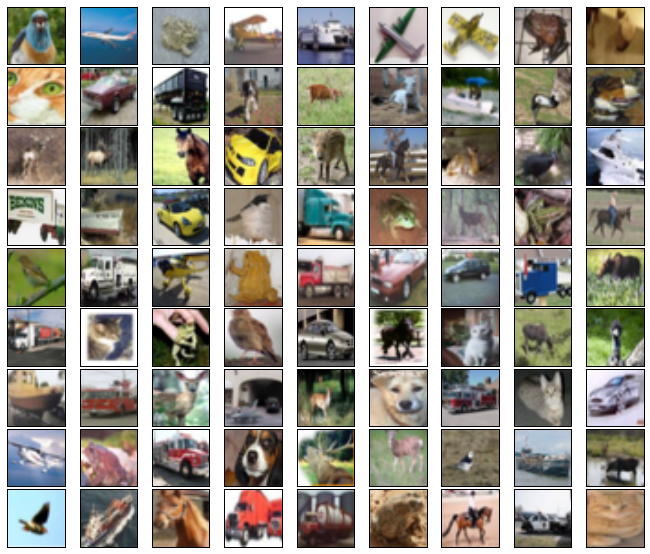

In [5]:
fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05, wspace=0.05)

for i in xrange(81):
    ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
    ax.imshow(train_X[i].transpose(1, 2, 0))

## 課題2. Data Augmentation
* Flipping (horizontally)
* Random cropping
* ...

### 1. Flipping (horizontally)

In [6]:
flip_train_X = train_X[:, :, :, ::-1]

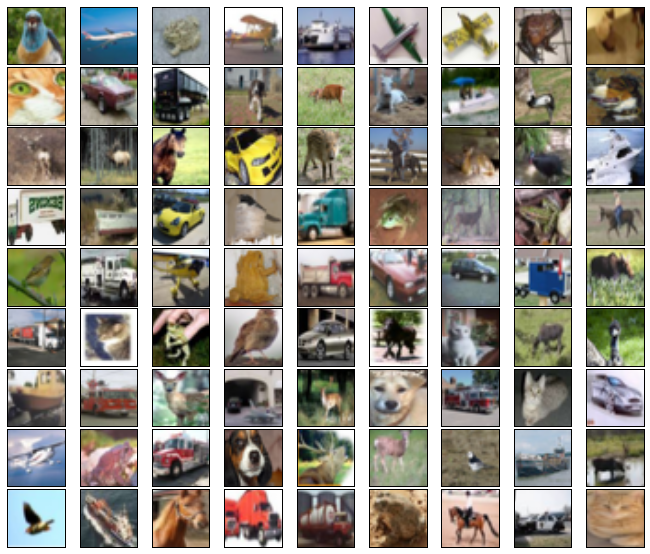

In [7]:
fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05, wspace=0.05)

for i in xrange(81):
    ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
    ax.imshow(flip_train_X[i].transpose(1, 2, 0))

### 2. Random cropping
* サイズを同じにするために，拡大したあとcropping，paddingしてからcroppingなどの方法がある．
* cropは学習時に各バッチに対して行うことも多い．
* 今回はDeep Residual Learning for Image Recognitionで使われた手法を実装

In [8]:
padded = np.pad(train_X, ((0, 0),(0, 0), (4, 4), (4, 4)), mode='constant')
crops = np.random.randint(8, size=(len(train_X), 2))
cropped_train_X = [padded[i, :, c[0]:(c[0]+32), c[1]:(c[1]+32)] for i, c in enumerate(crops)]
cropped_train_X = np.array(cropped_train_X)

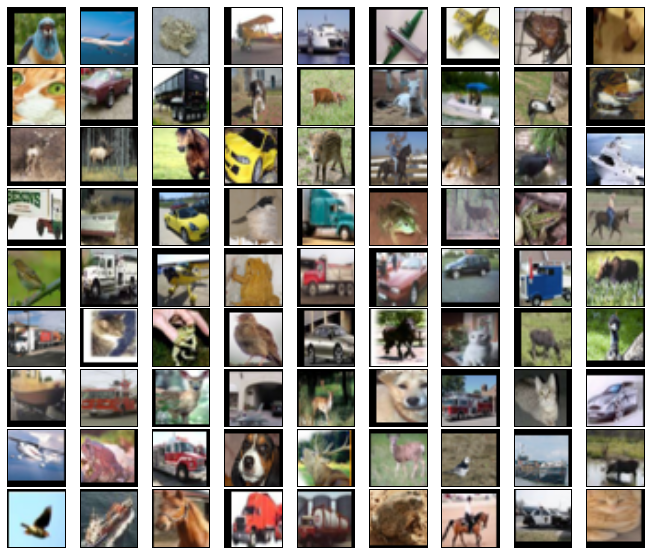

In [9]:
fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05, wspace=0.05)

for i in xrange(81):
    ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
    ax.imshow(cropped_train_X[i].transpose(1, 2, 0))

## 課題3. Preprocessing
* Global Contrast Normalization (GCN)
* ZCA Whitening
* ...

### 1. Global Contrast Normalization (GCN)
${\bf x}^{norm}=\frac{{\bf x}-\overline{{\bf x}}}{\sqrt{\sigma_{\bf x}}}$
* 通常の標準化とは違い，画像ごと
* コントラストが低くなる

In [10]:
def gcn(x):
    mean = np.mean(x, axis=(1,2,3), keepdims=True)
    std = np.std(x, axis=(1,2,3), keepdims=True)
    return (x - mean)/std

In [11]:
normalized_train_X = gcn(train_X)

In [12]:
# 可視化用に画像を[0,1]にする&次元を変更
def deprocess(x):
    _min = np.min(x)
    _max = np.max(x)
    _x = (x - _min)/(_max - _min)
    _x = _x.transpose((0, 2, 3, 1))
    return _x

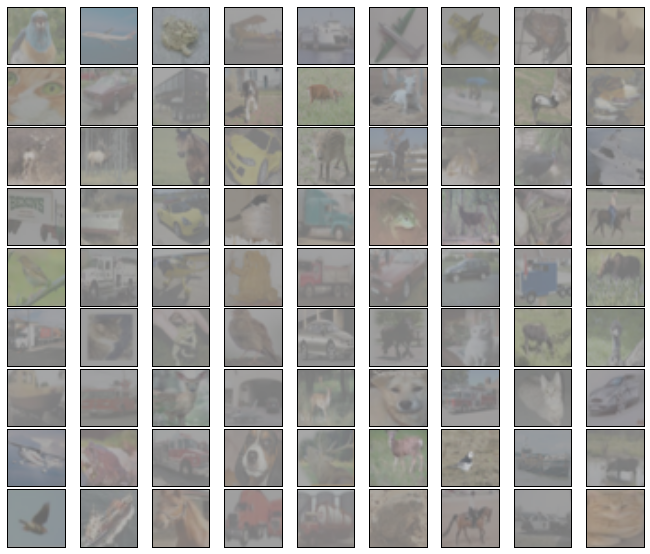

In [13]:
_normalized_train_X = deprocess(normalized_train_X)
fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05, wspace=0.05)

for i in xrange(81):
    ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
    ax.imshow(_normalized_train_X[i])
    
del _normalized_train_X

### 2. Zero-phase Component Analysis (ZCA) Whitening
${\bf x}^{ZCA}=A(\Lambda+\epsilon I)^{-\frac{1}{2}}A^T({\bf x}-\overline{{\bf x}})$
* np.linalg.svdを使うと便利（厳密にはnp.linalg.svdは特異値分解）

In [14]:
class ZCAWhitening:
    
    def __init__(self, epsilon=1e-4):
        self.epsilon = epsilon
        self.mean = None
        self.ZCA_matrix = None
    
    def fit(self, x):
        x = x.reshape(x.shape[0],-1)
        self.mean = np.mean(x,axis=0)
        x -= self.mean
        cov_matrix = np.dot(x.T, x)/x.shape[0]# WRITE ME
        A, d, _ = np.linalg.svd(cov_matrix)
        self.ZCA_matrix = np.dot(np.dot(A,np.diag(1.0 / np.sqrt(d + self.epsilon))),A.T) # WRITE ME

    def transform(self, x):
        shape = x.shape
        x = x.reshape(x.shape[0], -1)
        x -= self.mean
        x = np.dot(x,self.ZCA_matrix.T)
        return x.reshape(shape)

In [15]:
zca = ZCAWhitening()
zca.fit(train_X)
zca_train_X = zca.transform(train_X)

In [16]:
# 可視化用に各画像ごとに[0,1]にする(ZCAの結果を見やすくするため)&次元を変更
def deprocess_each_img(x):
    _min = np.min(x,axis=(1,2,3),keepdims=True)
    _max = np.max(x,axis=(1,2,3),keepdims=True)
    _x = (x - _min)/(_max - _min)
    _x = _x.transpose((0, 2, 3, 1))
    return _x

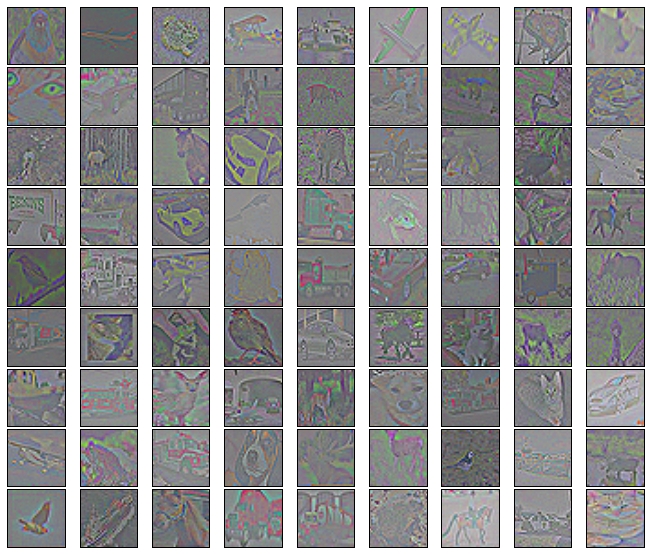

In [17]:
_zca_train_X = deprocess_each_img(zca_train_X)

fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05, wspace=0.05)

for i in xrange(81):
    ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
    ax.imshow(_zca_train_X[i])
    
del _zca_train_X

## 課題4. Batch Normalization
![](https://standardfrancis.files.wordpress.com/2015/04/screenshot-from-2015-04-16-133436.png?w=1008)

In [18]:
class BatchNorm:
    #- Constructor
    def __init__(self, shape, epsilon=np.float32(1e-5)):
        self.shape = shape
        self.epsilon = epsilon
        
        self.gamma = theano.shared(np.ones(self.shape, dtype="float32"), name="gamma")
        self.beta = theano.shared(np.zeros(self.shape, dtype="float32"), name="beta")
        self.params = [self.gamma, self.beta]
        
    #- Forward Propagation
    def f_prop(self, x):
        if x.ndim == 2:
            mean = T.mean(x, axis=0, keepdims=True)# WRITE ME
            std = T.sqrt(T.var(x, axis=0, keepdims=True) + self.epsilon)# WRITE ME
        elif x.ndim == 4:
            mean = T.mean(x, axis=(0,2,3), keepdims=True)# WRITE ME (HINT : ndim=4のときはフィルタの次元でも平均をとる)
            std = T.sqrt(T.var(x, axis=(0,2,3), keepdims=True) + self.epsilon)# WRITE ME
        
        normalized_x = (x - mean) / std# WRITE ME
        self.z = self.gamma * normalized_x + self.beta# WRITE ME
        return self.z

## 課題5. 畳み込みニューラルネットワーク(Convolutional Neural Networks)の実装と学習

### 1. 畳み込み層(Convolutional Layer)の実装

In [19]:
class Conv:
    #- Constructor
    def __init__(self, filter_shape, function=lambda x: x, border_mode="valid", subsample=(1, 1)):
        
        self.function = function
        self.border_mode = border_mode
        self.subsample = subsample
        
        fan_in = np.prod(filter_shape[1:])
        fan_out = (filter_shape[0] * np.prod(filter_shape[2:]))
        
        # Xavier
        self.W = theano.shared(rng.uniform(
                    low=-np.sqrt(6. / (fan_in + fan_out)),
                    high=np.sqrt(6. / (fan_in + fan_out)),
                    size=filter_shape
                ).astype("float32"), name="W")
        self.b = theano.shared(np.zeros((filter_shape[0],), dtype="float32"), name="b")
        self.params = [self.W,self.b]
        
    #- Forward Propagation
    def f_prop(self, x):
        conv_out = conv2d(x, self.W, border_mode=self.border_mode, subsample=self.subsample)
        self.z = self.function(conv_out + self.b[np.newaxis, :, np.newaxis, np.newaxis])
        return self.z

### 2. プーリング層(Pooling Layer)の実装

In [20]:
class Pooling:
    #- Constructor
    def __init__(self, pool_size=(2,2), padding=(0,0), mode='max'):
        self.pool_size = pool_size
        self.mode = mode
        self.padding = padding
        self.params = []
        
    #- Forward Propagation
    def f_prop(self, x):
        return pool.pool_2d(input=x, ds=self.pool_size, padding=self.padding, mode=self.mode, ignore_border=True)

### 3. 平滑化層(Flatten Layer)

In [21]:
class Flatten:
    #- Constructor
    def __init__(self, outdim=2):
        self.outdim = outdim
        self.params = []

    #- Forward Propagation
    def f_prop(self,x):
        return T.flatten(x, self.outdim)

### 4. 全結合層

In [22]:
class Layer:
    #- Constructor
    def __init__(self, in_dim, out_dim, function):
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.function = function

        self.W = theano.shared(rng.uniform(
                    low=-np.sqrt(6. / (in_dim + out_dim)),
                    high=np.sqrt(6. / (in_dim + out_dim)),
                    size=(in_dim,out_dim)
                ).astype("float32"), name="W")

        self.b =  theano.shared(np.zeros(out_dim).astype("float32"), name="b")
        self.params = [ self.W, self.b ]
        
    #- Forward Propagation
    def f_prop(self, x):
        self.z = self.function(T.dot(x, self.W) + self.b)
        return self.z

### 5. 活性化層

In [23]:
class Activation:
    #- Constructor
    def __init__(self, function):
        self.function = function
        self.params = []
    
    #- Forward Propagation
    def f_prop(self, x):
        self.z = self.function(x)
        return self.z

### 6. 更新則

In [24]:
#--- Stochastic Gradient Descent
def sgd(params, g_params, eps=np.float32(0.1)):
    updates = OrderedDict()
    for param, g_param in zip(params, g_params):
        updates[param] = param - eps*g_param
    return updates

### 7. ネットワークの定義

In [25]:
activation = T.nnet.relu

layers = [                               # (チャネル数)x(縦の次元数)x(横の次元数)
    Conv((32, 3, 3, 3)),                 #   3x32x32 ->  32x30x30
    BatchNorm((32, 30, 30)),
    Activation(activation),
    Pooling((2, 2)),                     #  32x30x30 ->  32x15x15
    Conv((64, 32, 3, 3)),                #  32x15x15 ->  64x13x13
    BatchNorm((64, 13, 13)),
    Pooling((2, 2)),                     #  64x13x13 ->  64x 6x 6
    Conv((128, 64, 3, 3)),               #  64x 6x 6 -> 128x 4x 4
    BatchNorm((128, 4, 4)),
    Activation(activation),
    Pooling((2, 2)),                     # 128x 4x 4 -> 128x 2x 2
    Flatten(2),
    Layer(128*2*2, 256, activation),
    Layer(256, 10, T.nnet.softmax)
]

### 8. train関数とtest関数とvalid関数

In [26]:
x = T.ftensor4('x')
t = T.imatrix('t')

params = []
layer_out = x
for layer in layers:
    params += layer.params
    layer_out = layer.f_prop(layer_out)

y = layers[-1].z

cost = T.mean(T.nnet.categorical_crossentropy(y, t))

g_params = T.grad(cost, params)
updates = sgd(params, g_params)

train = theano.function(inputs=[x, t], outputs=cost, updates=updates, allow_input_downcast=True, name='train')
valid = theano.function(inputs=[x, t], outputs=[cost, T.argmax(y, axis=1)], allow_input_downcast=True, name='valid')
test  = theano.function(inputs=[x], outputs=T.argmax(y, axis=1), name='test')

### 9. 学習

In [27]:
# Preprocessing
zca = ZCAWhitening()
zca.fit(gcn(train_X))
zca_train_X = zca.transform(gcn(train_X))
zca_train_y = train_y[:]
zca_valid_X = zca.transform(gcn(valid_X))
zca_valid_y = valid_y[:]

In [28]:
batch_size = 100
n_batches = zca_train_X.shape[0]//batch_size
for epoch in xrange(10):
    zca_train_X, zca_train_y = shuffle(zca_train_X, zca_train_y)
    for i in xrange(n_batches):
        start = i*batch_size
        end = start + batch_size
        cost = train(zca_train_X[start:end], zca_train_y[start:end])
    print 'Training cost: %.3f' % cost
    valid_cost, pred_y = valid(zca_valid_X, zca_valid_y)
    print 'EPOCH:: %i, Validation cost: %.3f, Validation F1: %.3f' % (epoch + 1, valid_cost, f1_score(np.argmax(zca_valid_y, axis=1).astype('int32'), pred_y, average='macro'))

Training cost: 1.166
EPOCH:: 1, Validation cost: 1.151, Validation F1: 0.584
Training cost: 1.144
EPOCH:: 2, Validation cost: 0.962, Validation F1: 0.667
Training cost: 0.889
EPOCH:: 3, Validation cost: 0.905, Validation F1: 0.673
Training cost: 0.672
EPOCH:: 4, Validation cost: 0.851, Validation F1: 0.707
Training cost: 0.690
EPOCH:: 5, Validation cost: 0.850, Validation F1: 0.710
Training cost: 0.564
EPOCH:: 6, Validation cost: 0.851, Validation F1: 0.714
Training cost: 0.766
EPOCH:: 7, Validation cost: 1.124, Validation F1: 0.652
Training cost: 0.504
EPOCH:: 8, Validation cost: 0.889, Validation F1: 0.712
Training cost: 0.490
EPOCH:: 9, Validation cost: 0.938, Validation F1: 0.709
Training cost: 0.238
EPOCH:: 10, Validation cost: 0.936, Validation F1: 0.717


## 課題6. 学習の重みの可視化

### 1. conv1

In [29]:
w0 = layers[0].W.get_value()

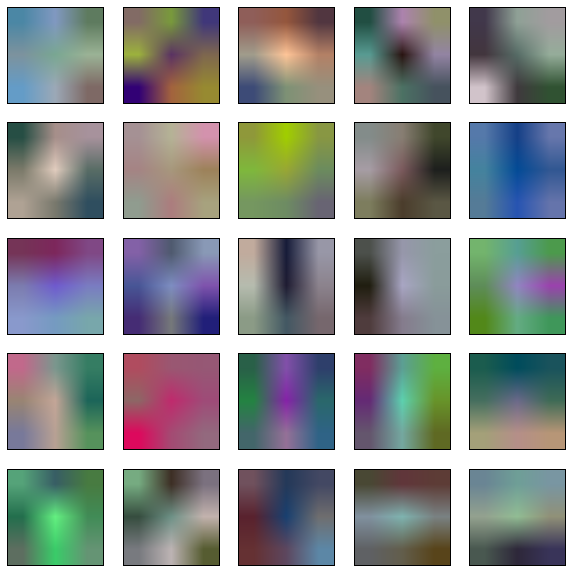

In [30]:
_w0 = deprocess(w0)
fig = plt.figure(figsize=(10, 10))
for i in xrange(25):
    ax = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(_w0[i])

### 2. conv2

In [31]:
w1 = layers[4].W.get_value()

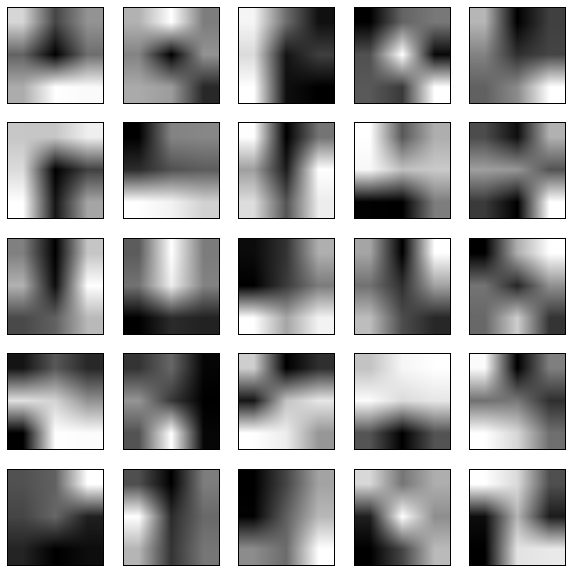

In [32]:
_w1 = deprocess(w1)
fig = plt.figure(figsize=(10, 10))
for i in xrange(25):
    ax = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(_w1[i,:,:,0],cmap='gray') # channel 0

### 3. conv3

In [33]:
w2 = layers[7].W.get_value()

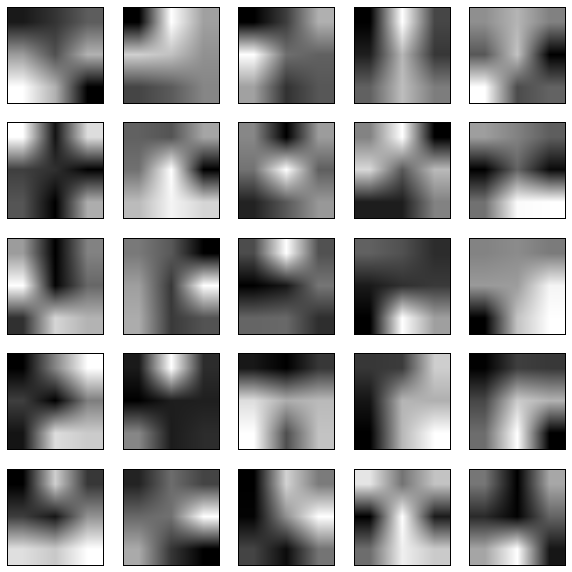

In [34]:
_w2 = deprocess(w2)
fig = plt.figure(figsize=(10, 10))
for i in xrange(25):
    ax = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(_w2[i,:,:,0],cmap='gray') # channel 0

## 課題7. Activationの可視化

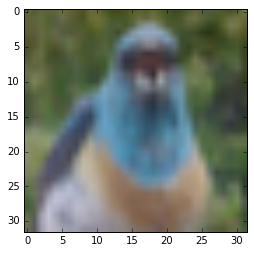

In [35]:
plt.imshow(deprocess(train_X)[0])

### 1. conv1

In [36]:
x = T.ftensor4('x')

plot_layer = 0

layer_out = x
for layer in layers[:plot_layer+1]:
    layer_out = layer.f_prop(layer_out)

f = theano.function(inputs=[x], outputs=layer_out)

In [37]:
output = f(train_X[0][np.newaxis])

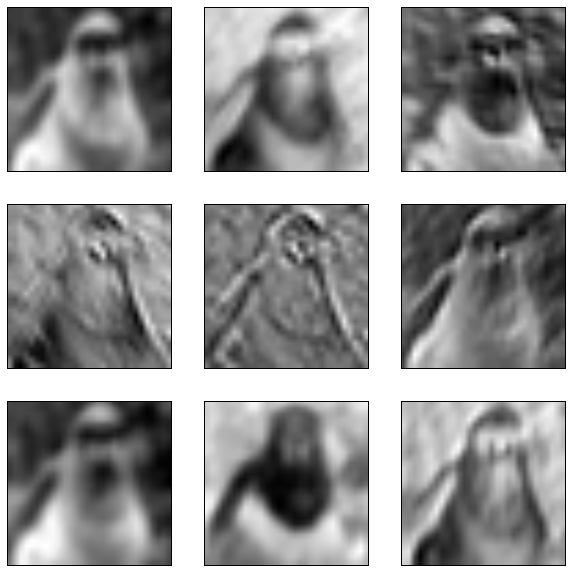

In [38]:
_output = deprocess(output)
fig = plt.figure(figsize=(10, 10))
for i in xrange(9):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(_output[0,:,:,i],cmap='gray')

### 2. conv2

In [39]:
x = T.ftensor4('x')

plot_layer = 4

layer_out = x
for layer in layers[:plot_layer+1]:
    layer_out = layer.f_prop(layer_out)

f = theano.function(inputs=[x], outputs=layer_out)

In [40]:
output = f(train_X[0][np.newaxis])

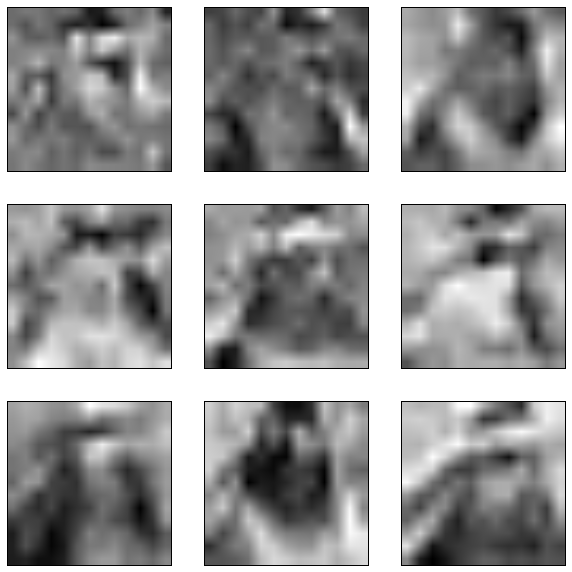

In [41]:
_output = deprocess(output)
fig = plt.figure(figsize=(10, 10))
for i in xrange(9):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(_output[0,:,:,i],cmap='gray')

### 3. conv3

In [42]:
x = T.ftensor4('x')

plot_layer = 7

layer_out = x
for layer in layers[:plot_layer+1]:
    layer_out = layer.f_prop(layer_out)

f = theano.function(inputs=[x], outputs=layer_out)

In [43]:
output = f(train_X[0][np.newaxis])

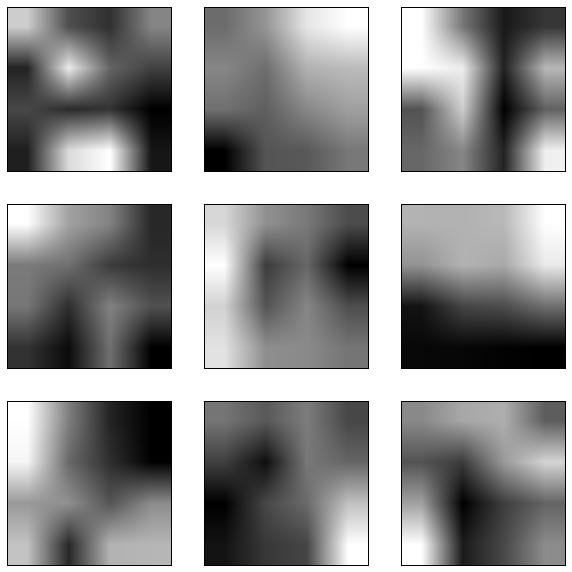

In [44]:
_output = deprocess(output)
fig = plt.figure(figsize=(10, 10))
for i in xrange(9):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(_output[0,:,:,i],cmap='gray')